In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 3.2e-7 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 40
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 7000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

280000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

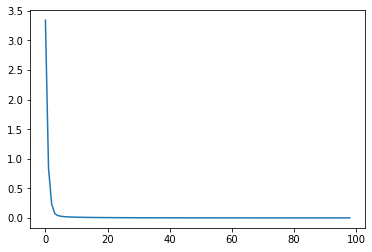

In [8]:
plt.plot(S)

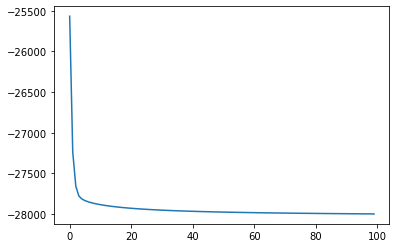

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0005334569952974562

In [11]:
eta

array([-25567.12039766, -27238.14583323, -27659.13014927, -27779.16608418,
       -27816.25925299, -27836.1184499 , -27850.13567092, -27861.21615721,
       -27870.48706137, -27878.5028743 , -27885.58013847, -27891.91900315,
       -27897.65579363, -27902.88872438, -27907.69169016, -27912.12221605,
       -27916.22631562, -27920.04160749, -27923.59939812, -27926.92612391,
       -27930.04438056, -27932.97367781, -27935.73100589, -27938.33126963,
       -27940.78762715, -27943.11175855, -27945.31408197, -27947.4039297 ,
       -27949.38969321, -27951.27894391, -27953.07853447, -27954.79468467,
       -27956.43305444, -27957.99880665, -27959.49666123, -27960.93094209,
       -27962.30561804, -27963.62433858, -27964.89046538, -27966.10710003,
       -27967.27710854, -27968.40314316, -27969.48766178, -27970.53294519,
       -27971.54111261, -27972.51413554, -27973.45385026, -27974.36196903,
       -27975.24009029, -27976.08970776, -27976.91221878, -27977.70893183,
       -27978.48107337, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([2.43227961e+03, 7.61254171e+02, 3.40269855e+02, 2.20233920e+02,
       1.83140751e+02, 1.63281554e+02, 1.49264333e+02, 1.38183847e+02,
       1.28912943e+02, 1.20897130e+02, 1.13819865e+02, 1.07481001e+02,
       1.01744210e+02, 9.65112795e+01, 9.17083137e+01, 8.72777878e+01,
       8.31736882e+01, 7.93583964e+01, 7.58006058e+01, 7.24738800e+01,
       6.93556233e+01, 6.64263261e+01, 6.36689980e+01, 6.10687342e+01,
       5.86123767e+01, 5.62882453e+01, 5.40859219e+01, 5.19960742e+01,
       5.00103107e+01, 4.81210600e+01, 4.63214694e+01, 4.46053192e+01,
       4.29669494e+01, 4.14011972e+01, 3.99033426e+01, 3.84690618e+01,
       3.70943858e+01, 3.57756653e+01, 3.45095385e+01, 3.32929038e+01,
       3.21228953e+01, 3.09968607e+01, 2.99123421e+01, 2.88670587e+01,
       2.78588913e+01, 2.68858683e+01, 2.59461536e+01, 2.50380348e+01,
       2.41599136e+01, 2.33102961e+01, 2.24877851e+01, 2.16910720e+01,
       2.09189305e+01, 2.01702098e+01, 1.94438294e+01, 1.87387737e+01,
      

In [15]:
# save csv files

np.savetxt('elevation csv files/eta_exp_2.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_2.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_2.csv', S, delimiter = ',')